# Abalone Data 

This is a Jupyter notebook documenting the data cleaning and analysis of the abalone dataset (see https://archive.ics.uci.edu/ml/datasets/abalone)
The dataset abalone.data is given with the following columns (from left to right):

    Name		Data Type	Meas.	Description
	----		---------	-----	-----------
	Sex		nominal		M, F, and I (infant)
	Length		continuous	mm	Longest shell measurement
	Diameter	continuous	mm	perpendicular to length
	Height		continuous	mm	with meat in shell
	Whole weight	continuous	grams	whole abalone
	Shucked weight	continuous	grams	weight of meat
	Viscera weight	continuous	grams	gut weight (after bleeding)
	Shell weight	continuous	grams	after being dried
	Rings		integer			+1.5 gives the age in years
The aim is, given the main characteristics, predict the number of rings in the abalone and hence its age in years.

In [15]:
import numpy as np
import seaborn as sb
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
### Column names
col_name = ["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight", "Rings"]

### Function for cleaning data (note: we only need to replace the Sex column with numerical equivalents)
def data_clean(): 
    with open('abalone.data', 'r') as abalone:
        abalonedata = abalone.read()

        # Replace the target string with a one-hot encoding
        abalonedata = abalonedata.replace('M', '0')
        abalonedata = abalonedata.replace('F', '1')
        abalonedata = abalonedata.replace('I', '2')

        # Write the file out again
        with open('abalone_clean.csv', 'w') as file: ### w will create new file if it doesn't already exist 
            file.write(abalonedata)
    return  

### Function for loading the data into a pandas dataframe
def dataloader():
    abalone = np.genfromtxt("abalone_clean.csv", delimiter=",")
    abalone = pd.DataFrame(abalone, columns=col_name)
    return abalone 

In [3]:
data_clean() ### Clean data and producee output in abalone_clean.csv


In [53]:
abalone = dataloader() #Load and print dataframe

In [54]:
abalone.describe() #View summary statistics. There are exactly 4177 abalones studied, with the mean number of rings 
#being approximately 10. The middle 50% of abalones have betweeen 8 and 11 rings, with min being 1 and max being 29, 
#suggesting a lack of very young and very old abalones. This may cause class imbalance issues later - we will group and 
#count the abalone by ring quartiles.

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.955470,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.827815,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.000000,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.000000,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,1.000000,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,2.000000,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,2.000000,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


<ipython-input-55-92f32748086d>:9: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  abalone.hist(ax = ax)


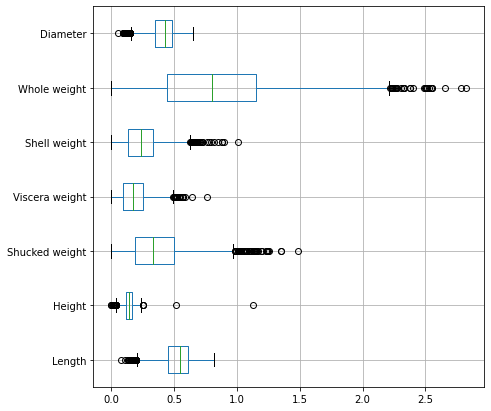

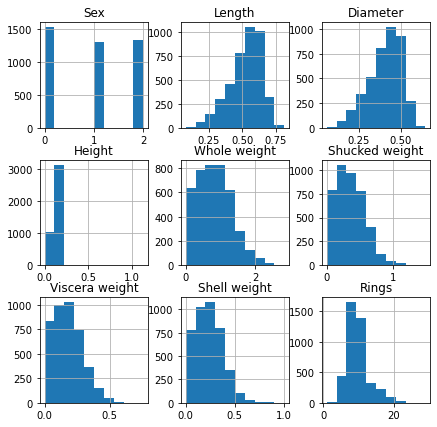

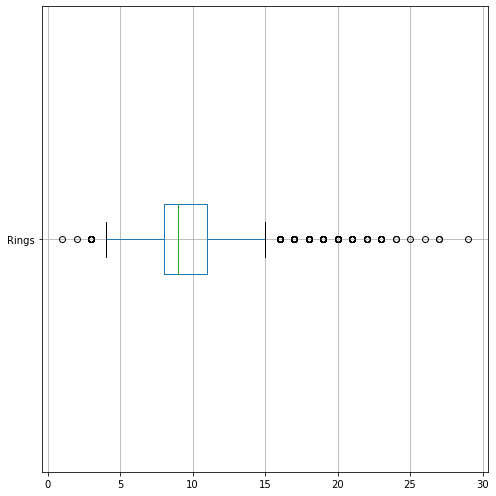

In [55]:
# Make histograms and boxplots for each feature
column_box = list(set(col_name) - set(["Rings", "Sex"]))

fig1 = plt.figure(figsize = (7,7))
abalone.boxplot(column=column_box, vert = False)
plt.savefig("abalone_boxplot.jpg")

fig2, ax = plt.subplots(figsize = (7,7))
abalone.hist(ax = ax)
plt.savefig("abalone_hist.jpg")

fig3 = plt.figure(figsize = (7,7))
abalone.boxplot(column="Rings", vert = False)
plt.savefig("abalone_rings.jpg")


plt.tight_layout()
plt.show()

[[24.24315319 11.26412772 14.07804158 ... 14.08005333 15.51264584
  18.6894933 ]
 [11.26412772  5.2364083   6.53862968 ...  6.54002849  7.20221484
   8.67546537]
 [14.07804158  6.53862968  8.25773634 ...  8.1618864   9.08513195
  10.83488903]
 ...
 [14.08005333  6.54002849  8.1618864  ...  8.23607972  9.02323895
  10.96336509]
 [15.51264584  7.20221484  9.08513195 ...  9.02323895 10.01347219
  11.99743908]
 [18.6894933   8.67546537 10.83488903 ... 10.96336509 11.99743908
  14.61986247]]


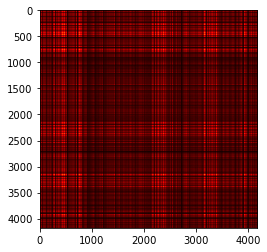

In [59]:
# Construct covariance matrix
abalone_cov = np.cov(abalone, bias = False) #bias = False is for 1/N-1 factor
print(abalone_cov)

# Produce heatmap using matplotlib and seaborn
#heat_map = sb.heatmap(abalone_cov, cmap="flare", annot = True)
#plt.show()

plt.imshow(abalone_cov, cmap='hot', interpolation='nearest')
plt.savefig("abalone_heatmap.jpg")
plt.show()


As we alluded to earlier, we can sort the ring ages into the quantiles to check for any imbalance in the data.
As we can see from the output below, the majority of the abalones in the first 75% of the age range, and there are almost no abalones
that are old.

<AxesSubplot:xlabel='quartiles'>

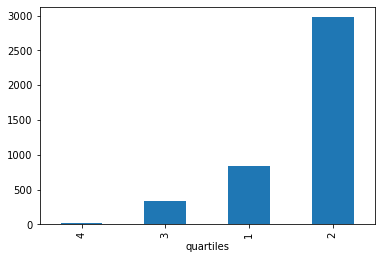

In [129]:
### grouping by size
abalone_sizes = abalone.groupby("Rings").size().reset_index(name = "Count")

quartiles = abalone_sizes["Rings"].quantile([.25,.5,.75]).tolist() #Creates list of quartile bins
quartiles = [0] + quartiles + [float('inf')] #Adds 0 and INF bins

abalone_sizes["quartiles"] = pd.cut(abalone_sizes["Rings"], bins=quartiles, labels=[1,2,3,4]) #Add column "quartiles" to abalone sizes

#group by quartiles, take the count column, sum up count (groupby places wrt quartiles) and sort then plot
#if you don't specify which column to sum up, it will sum up everything including rings
abalone_sizes.groupby("quartiles")["Count"].sum().sort_values().plot(kind="bar")
